##### DeltaServe Plotting

In [1]:
from typing import Dict, List, Union
import os
import sys
import pytz
import pickle

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.ticker import FixedLocator

from glob import glob
from collections import Counter
from datetime import datetime
from pathlib import Path

from utils import parse_data, get_sys_name, get_sys_name_wo_format, color_palette, get_short_system_name


DATAPATH = "../.artifact/benchmarks/results"
SAVEPATH = "./figure"

pd.set_option("display.max_columns", 500)

sns.set_style("ticks")
font = {
    "font.family": "Roboto",
    "font.size": 12,
}
sns.set_style(font)
paper_rc = {
    "lines.linewidth": 3,
    "lines.markersize": 10,
}
sns.set_context("paper", font_scale=2, rc=paper_rc)
cmp = sns.color_palette("tab10")

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42


def autolabel(rects, ax, prec=1):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(
            f"{height:.{prec}f}",
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha="center",
            va="bottom",
            size=13,
        )


def read_csv_with_concat(path="./csv", file_name=None):
    file = Path(path, f"{file_name}.csv")

    if file.exists():
        # If original file exists, read it directly
        df = pd.read_csv(file)
        print(f"Reading {file_name}")
    else:
        # If original file does not exist, read all the split files
        split_files = sorted(glob(f"{path}/{file_name}-2023-*.csv"))
        print(f"Reading splitted files: {split_files}")
        df = pd.concat([pd.read_csv(split_file) for split_file in split_files])
        df.reset_index(drop=True, inplace=True)
    return df


def calculate_sum_cdf_axis100(df, dot_num=1000):
    """
    Calculate quantity percentile CDF, y-axis: 0-100%,
    """
    print("Parsing")
    data = df.melt(id_vars="Time", var_name="Server")
    data.dropna(subset=["value"], inplace=True)
    # data.sort_values('value', ascending=True, inplace=True)
    # data.reset_index(drop=True, inplace=True)

    y = np.linspace(0, 1, num=dot_num)
    x = data["value"].quantile(y).values
    y = y * 100
    return x, y


def calculate_num_cdf_customized_xaxis(df: pd.DataFrame, x_axis: List, key: str):
    """
    Calculate quantity percentile CDF with customized threshold of x-axis, y-axis: 0-100%,
    """
    # print("Parsing")
    data = df[[key]].copy()
    data.dropna(inplace=True)

    y = [len(data[data[key] <= x]) / len(data) * 100 for x in x_axis]

    return y


def calculate_sum_cdf_customized_xaxis(df: pd.DataFrame, x_axis: List, key: str, key_to_time=None):
    """
    Calculate sum CDF with customized threshold of x-axis, y-axis: 0-100%,
    """
    # print("Parsing")
    if key_to_time is not None:
        data = df[[key, key_to_time]].copy()
        data["new"] = data[key] * data[key_to_time]
    else:
        data = df[[key]].copy()
        data["new"] = data[key]
    data.dropna(inplace=True)
    sum = data["new"].sum()

    y = [data[data[key] <= x]["new"].sum() / sum * 100 for x in x_axis]

    return y

#### Bar: Motivation, Compare with LoRA

/tmp/ipykernel_3116620/3788741884.py:70: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


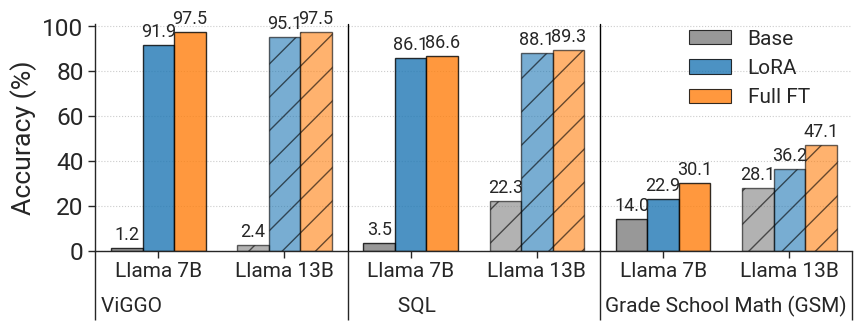

In [13]:
fig, ax = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(9, 3.75))
cmp = sns.color_palette("tab10")

df = pd.read_csv(f"./anyscale_ft_benchmark.csv")

x = np.arange(1, 7)
width = 0.25

ft_list = ["Base", "LoRA", "Full FT"]
x_label = ["Llama 7B", "Llama 13B"] * 3
color_list = [cmp[-3], cmp[0], cmp[1]]

for i, method in enumerate(ft_list):
    sub_df = df[df["Model"] == method]
    bars = ax.bar(
        x - width * (1 - i),
        sub_df["Accuracy"] * 100,
        width=width,
        label="Origin",
        alpha=0.8,
        linewidth=1,
        edgecolor="k",
        color=[color_list[i]],
    )

    for i, bar in enumerate(bars):
        if i % 2 == 1:
            bar.set_hatch("/")
            bar.set_alpha(0.6)
        else:
            bar.set_alpha(0.8)

    autolabel(bars, ax)


ax.set_xlabel(
    f"ViGGO	                                             SQL                                 Grade School Math (GSM)",
    size=15,
)
ax.xaxis.labelpad = 1.0
ax.set_ylabel(f"Accuracy (%)")
ax.set_xticks(x)
ax.set_yticks(np.arange(0, 101, 20))
ax.set_xticklabels(x_label, size=15)
ax.set_xlim(0.5, 6.5)
ax.set_ylim(0, 101)
ax.grid(axis="y", linestyle=":")
sns.despine()

ax.axvline(x=2.5, ls="-", c="k", lw=1, clip_on=False)
ax.axvline(x=4.5, ls="-", c="k", lw=1, clip_on=False)
ax.xaxis.set_minor_locator(FixedLocator([0.5, 2.5, 4.5, 6.5]))
ax.xaxis.set_label_coords(0.5, -0.2)
ax.tick_params("x", length=50, width=1, which="minor")


A = mpatches.Patch(facecolor=color_list[0], edgecolor="black", alpha=0.8, label=ft_list[0])
B = mpatches.Patch(facecolor=color_list[1], edgecolor="black", alpha=0.8, label=ft_list[1])
C = mpatches.Patch(facecolor=color_list[2], edgecolor="black", alpha=0.8, label=ft_list[2])
ax.legend(
    handles=[A, B, C],
    bbox_to_anchor=(0.76, 0.55),
    ncol=1,
    frameon=False,
    fancybox=True,
    shadow=True,
    fontsize=15,
)

fig.tight_layout()

# A = mpatches.Patch(facecolor="white", edgecolor="black", label="7B")
# B = mpatches.Patch(facecolor="white", edgecolor="black", hatch="/", label="13B")
# ax.legend(
#     handles=[A, B],
#     bbox_to_anchor=(0.76, 0.65),
#     ncol=1,
#     frameon=False,
#     fancybox=True,
#     shadow=True,
#     fontsize=15,
# )

fig.savefig(f"{SAVEPATH}/motivation_compare_lora.pdf", bbox_inches="tight")


#### Plot: Ablation Curve

systems: ['baselines', 'ours']


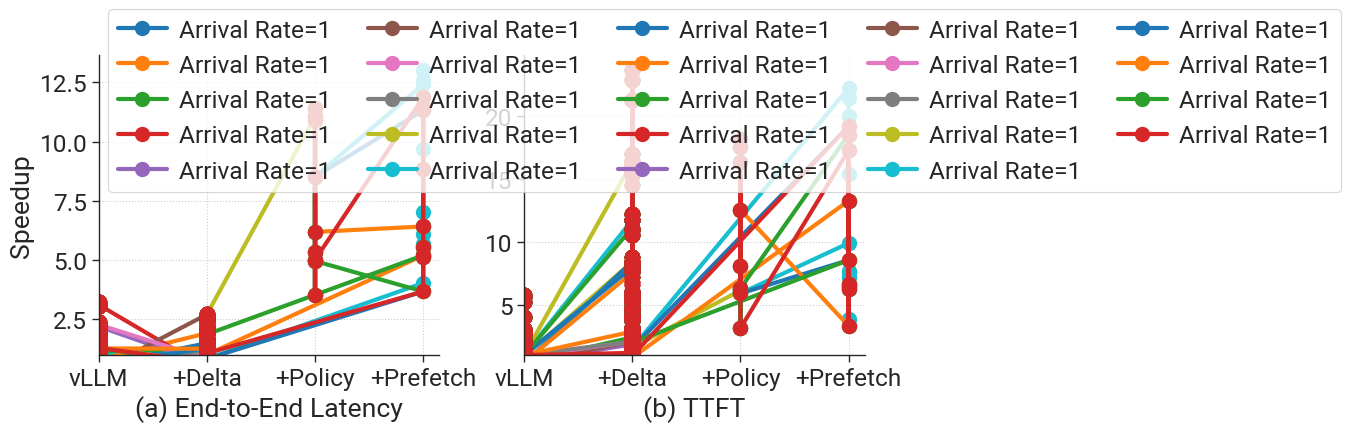

In [14]:
"""New"""

data_path = f"{DATAPATH}/pjlab"


systems_dir = [x for x in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, x))]
if "archived" in systems_dir:
    systems_dir.remove("archived")
print("systems:", systems_dir)

linestyles = ["-", "--", ":", ":", ":"]
grid_params = dict(width_ratios=[1, 1])
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, constrained_layout=True, figsize=(9, 3.75))

df = pd.DataFrame()
for sys in systems_dir:
    num_models = [x for x in os.listdir(os.path.join(data_path, sys)) if os.path.isdir(os.path.join(data_path, sys, x))]
    for num_model in num_models:
        files = [x for x in os.listdir(os.path.join(data_path, sys, num_model)) if x.endswith(".jsonl")]
        for file in files:
            metadata, data = parse_data(os.path.join(data_path, sys, num_model, file))
            focus_group = [x for x in data if x["type"] in ["E2E Latency", "TTFT"]]
            partial_df = pd.DataFrame(focus_group)
            partial_df["system"], partial_df["order"] = get_short_system_name(metadata)
            for key, value in metadata.items():
                partial_df[key] = value
            df = pd.concat([df, partial_df])

            avg_latency = df.groupby(["system", "type", "models", "distribution", "ar"])["time"].mean().reset_index()

            # normalized latency to the baseline-1 system
            baseline_latency = avg_latency[avg_latency.system == "Baseline-1"]
            # divide the latency of each type by the baseline-1 latency
            avg_latency = pd.merge(avg_latency, baseline_latency, on="type", suffixes=("", "_baseline"))
            avg_latency["speedup"] = avg_latency["time_baseline"] / avg_latency["time"]
            # order by order
            avg_latency = pd.merge(
                avg_latency,
                df[["system", "type", "order", "models", "distribution", "ar"]].drop_duplicates(),
                on=["system", "type"],
                how="left",
            )
            avg_latency = avg_latency.sort_values(by="order")

            ar_str = "1"
            for metric in ["E2E Latency", "TTFT"]:
                subdf = avg_latency[avg_latency.type == metric]
                subdf.loc[subdf["system"] == "Baseline-1", "system"] = "vLLM"
                if metric == "E2E Latency":
                    ax1.plot(subdf["system"], subdf["speedup"], "o-", label=f"Arrival Rate={ar_str}")
                    # {dist.capitalize()}, AR={ar_str}
                else:
                    ax2.plot(subdf["system"], subdf["speedup"], "o-", label=f"AR={ar_str}")

ax1.set_xlabel(f"(a) End-to-End Latency")
ax1.set_ylabel(f"Speedup")
ax1.set_xlim(0)
ax1.set_ylim(1)
ax1.grid(linestyle=":")

ax2.set_xlabel(f"(b) TTFT")
# ax2.set_ylabel(f"Speedup")
ax2.set_xlim(0)
ax2.set_ylim(1)
ax2.grid(linestyle=":")

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles=handles, labels=labels, ncols=5, bbox_to_anchor=(0.1, 1.145), loc=2, columnspacing=1.5, handletextpad=0.5)

sns.despine()


# fig.savefig(f"{SAVEPATH}/eval_ablation.pdf", bbox_inches="tight")

In [12]:
avg_latency

,system,type,models_x,distribution_x,ar_x,time,system_baseline,models_baseline,distribution_baseline,ar_baseline,time_baseline,speedup,order,models_y,distribution_y,ar_y
4049,Baseline-1,TTFT,32,uniform,9.0,823.471813,Baseline-1,32,azure,6.0,285.510336,0.346715,0,32,azure,3.0
4050,Baseline-1,TTFT,32,uniform,9.0,823.471813,Baseline-1,32,azure,9.0,366.810604,0.445444,0,32,uniform,3.0
4051,Baseline-1,TTFT,32,uniform,9.0,823.471813,Baseline-1,32,azure,9.0,366.810604,0.445444,0,32,azure,9.0
4052,Baseline-1,TTFT,32,uniform,9.0,823.471813,Baseline-1,32,azure,9.0,366.810604,0.445444,0,32,uniform,6.0
4053,Baseline-1,TTFT,32,uniform,9.0,823.471813,Baseline-1,32,azure,9.0,366.810604,0.445444,0,32,uniform,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2597,+Policy,E2E Latency,8,azure,3.0,92.036754,Baseline-1,32,azure,9.0,569.739574,6.190348,3,8,azure,3.0
2596,+Policy,E2E Latency,8,azure,3.0,92.036754,Baseline-1,32,azure,6.0,493.240782,5.359172,3,8,azure,3.0
2595,+Policy,E2E Latency,8,azure,3.0,92.036754,Baseline-1,32,azure,3.0,326.542746,3.547960,3,8,azure,3.0
2605,+Policy,TTFT,8,azure,3.0,45.389337,Baseline-1,32,azure,6.0,285.510336,6.290251,3,8,azure,3.0


In [10]:
df

,id,model,time,type,system,order,models,distribution,ar,duration,bitwidth,tp_size,is_swap,is_delta,is_unoptimized_delta,gen_tokens,is_nvme,enable_prefetch,policy
0,0,delta-3,105.100230,E2E Latency,Baseline-1,0,32,uniform,3.0,30.0,16,4,True,False,False,auto,False,False,fcfs
1,0,delta-3,99.243576,TTFT,Baseline-1,0,32,uniform,3.0,30.0,16,4,True,False,False,auto,False,False,fcfs
2,1,delta-3,105.402455,E2E Latency,Baseline-1,0,32,uniform,3.0,30.0,16,4,True,False,False,auto,False,False,fcfs
3,1,delta-3,99.545808,TTFT,Baseline-1,0,32,uniform,3.0,30.0,16,4,True,False,False,auto,False,False,fcfs
4,2,delta-3,95.848902,E2E Latency,Baseline-1,0,32,uniform,3.0,30.0,16,4,True,False,False,auto,False,False,fcfs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,93,delta-4,100.825139,TTFT,+Delta,1,16,uniform,3.0,30.0,4,4,False,True,False,auto,False,False,fcfs
188,94,delta-1,889.844472,E2E Latency,+Delta,1,16,uniform,3.0,30.0,4,4,False,True,False,auto,False,False,fcfs
189,94,delta-1,99.726093,TTFT,+Delta,1,16,uniform,3.0,30.0,4,4,False,True,False,auto,False,False,fcfs
190,95,/vllm/.idea/full_models/Llama-2-13b-hf,914.454597,E2E Latency,+Delta,1,16,uniform,3.0,30.0,4,4,False,True,False,auto,False,False,fcfs


In [7]:
avg_latency

,system,type,time,system_baseline,time_baseline,speedup,order,models,distribution,ar
31,Baseline-1,E2E Latency,683.738713,Baseline-1,683.738713,1.000000,0,32,uniform,9.0
30,Baseline-1,E2E Latency,683.738713,Baseline-1,683.738713,1.000000,0,32,uniform,6.0
29,Baseline-1,E2E Latency,683.738713,Baseline-1,683.738713,1.000000,0,32,azure,9.0
28,Baseline-1,E2E Latency,683.738713,Baseline-1,683.738713,1.000000,0,32,uniform,3.0
43,Baseline-1,TTFT,475.557859,Baseline-1,475.557859,1.000000,0,16,uniform,3.0
42,Baseline-1,TTFT,475.557859,Baseline-1,475.557859,1.000000,0,16,uniform,6.0
41,Baseline-1,TTFT,475.557859,Baseline-1,475.557859,1.000000,0,32,azure,6.0
40,Baseline-1,TTFT,475.557859,Baseline-1,475.557859,1.000000,0,32,uniform,9.0
39,Baseline-1,TTFT,475.557859,Baseline-1,475.557859,1.000000,0,32,uniform,6.0
38,Baseline-1,TTFT,475.557859,Baseline-1,475.557859,1.000000,0,32,azure,9.0


In [ ]:
"""Old"""

data_path = f"{DATAPATH}/13b/pjlab"

linestyles = ["-", "--", ":", ":", ":"]
grid_params = dict(width_ratios=[1, 1])
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, constrained_layout=True, figsize=(9, 3.75))


df_list = []

distributions = [x for x in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, x))]
for dist in distributions:
    arrival_rates = [x for x in os.listdir(os.path.join(data_path, dist)) if os.path.isdir(os.path.join(data_path, dist, x))]
    for ar in arrival_rates:
        ar_str = ar.split("=")[1]
        files = [x for x in os.listdir(os.path.join(data_path, dist, ar)) if x.endswith(".jsonl")]
        df = pd.DataFrame()
        distribution = []
        for file in files:
            metadata, data = parse_data(os.path.join(data_path, dist, ar, file))
            distribution.append(metadata["distribution"])
            focus_group = [x for x in data if x["type"] in ["E2E Latency", "TTFT"]]
            filename = data_path.split("/")[-1].removesuffix(".jsonl")
            partial_df = pd.DataFrame(focus_group)
            partial_df["system"], partial_df["order"] = get_short_system_name(metadata)
            df = pd.concat([df, partial_df])
        distribution = list(set(distribution))
        assert len(distribution) == 1, "Multiple distributions found"
        distribution = distribution[0]
        if distribution != "uniform" or ar_str == "9":
            continue
        print(f"Processing {dist} ar {ar_str}")
        # avg_latency = df.groupby(["system", "type"]).mean().reset_index()
        avg_latency = df.groupby(["system", "type"])["time"].mean().reset_index()

        # normalized latency to the baseline-1 system
        baseline_latency = avg_latency[avg_latency.system == "Baseline-1"]
        # divide the latency of each type by the baseline-1 latency
        avg_latency = pd.merge(avg_latency, baseline_latency, on="type", suffixes=("", "_baseline"))
        avg_latency = pd.merge(
            avg_latency, df[["system", "type", "order"]].drop_duplicates(), on=["system", "type"], how="left"
        )
        avg_latency["speedup"] = avg_latency["time_baseline"] / avg_latency["time"]
        # order by order
        avg_latency = avg_latency.sort_values(by="order")
        for metric in ["E2E Latency", "TTFT"]:
            subdf = avg_latency[avg_latency.type == metric]
            subdf.loc[subdf["system"] == "Baseline-1", "system"] = "Baseline"
            # subdf.replace({"system": {"Baseline-1": "Baseline"}}, inplace=True)
            if metric == "E2E Latency":
                ax1.plot(subdf["system"], subdf["speedup"], "o-", label=f"Arrival Rate={ar_str}")

                # {dist.capitalize()}, AR={ar_str}
            else:
                ax2.plot(subdf["system"], subdf["speedup"], "o-", label=f"{dist.capitalize()}, AR={ar_str}")


ax1.set_xlabel(f"(a) End-to-End Latency")
ax1.set_ylabel(f"Speedup")
ax1.set_xlim(0)
ax1.set_ylim(1)
ax1.grid(linestyle=":")

ax2.set_xlabel(f"(b) TTFT")
# ax2.set_ylabel(f"Speedup")
ax2.set_xlim(0)
ax2.set_ylim(1)
ax2.grid(linestyle=":")

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles=handles, labels=labels, ncols=5, bbox_to_anchor=(0.1, 1.145), loc=2, columnspacing=1.5, handletextpad=0.5)

sns.despine()
fig.savefig(f"{SAVEPATH}/eval_ablation.pdf", bbox_inches="tight")

#### Plot: Latency Breakdown

In [ ]:
data_path = f"{DATAPATH}/pjlab"
systems_dir = ["baselines/nm.16", "ours"]
df = pd.DataFrame()

linestyles = ["-", "--", ":", ":", ":"]
grid_params = dict(width_ratios=[1, 1])
# fig, axs = plt.subplots(ncols=2, nrows=1, constrained_layout=True, figsize=(9, 3.75))
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, constrained_layout=True, figsize=(9, 3.75))
width = 10
cmp = sns.color_palette("tab10")

for sys in systems_dir:
    files = [x for x in os.listdir(os.path.join(data_path, sys)) if x.endswith(".jsonl")]
    for file in files:
        metadata, data = parse_data(os.path.join(data_path, sys, file))
        if metadata["bitwidth"] == 2:
            continue
        title = get_sys_name_wo_format(metadata)
        except_e2e = [x for x in data if x["type"] not in ["E2E Latency", "TTFT"]]
        filename = data_path.split("/")[-1].removesuffix(".jsonl")
        partial_df = pd.DataFrame(except_e2e)
        partial_df["system"] = title
        df = pd.concat([df, partial_df])

systems = list(df.system.unique())
systems = sorted(systems, reverse=True)


for i, system in enumerate(systems):
    system_df = df[df.system == system]
    # axs[i].bar(system_df["id"], system_df["time"], width)
    if i == 0:
        A = ax1.bar(
            system_df[system_df["type"] == "Loading"]["id"],
            system_df[system_df["type"] == "Loading"]["time"],
            width=width,
            edgecolor="k",
            label="Loading",
            alpha=0.75,
            color=[cmp[0]],
        )
        B = ax1.bar(
            system_df[system_df["type"] == "Inference"]["id"],
            system_df[system_df["type"] == "Inference"]["time"],
            bottom=system_df[system_df["type"] == "Loading"]["time"],
            width=width,
            edgecolor="k",
            label="Inference",
            alpha=0.75,
            color=[cmp[1]],
        )
        # C = ax1.bar(
        #     system_df[system_df["type"] == "Queueing"]["id"],
        #     system_df[system_df["type"] == "Queueing"]["time"],
        #     bottom=system_df[system_df["type"] == "Loading"]["time"] + system_df[system_df["type"] == "Inference"]["time"],
        #     width=width,
        #     edgecolor="k",
        #     label="Queueing",
        #     alpha=0.75,
        #     color=[cmp[1]],
        # )

    # for fig2_data in fig2["data"]:
    #     fig.add_trace(
    #         go.Bar(
    #             x=fig2_data["x"],
    #             y=fig2_data["y"],
    #             marker=fig2_data["marker"],
    #             name=fig2_data["name"],
    #             showlegend=True if i == 0 else False,
    #         ),
    #         row=1,
    #         col=i + 1,
    #     )

In [ ]:
system_df[system_df["type"] == "Inference"]["id"]

In [ ]:
systems

In [ ]:
ax.bar(x, activation, width, bottom=np.array(other), edgecolor="k", label="Activation", alpha=0.75, color=[cmp[3]])

In [ ]:
axs[i].bar

In [ ]:
system_df[system_df["type"] == "Inference"].sort_values(by="id")